# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучим модель, которая сможет классифицировать комментарии на позитивные и негативные, используя набор данных с разметкой о токсичности правок. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак. Построим модель со значением метрики качества *F1* не меньше 0.75. 

# Предобработка текстов

Импортируем библиотеки:

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = stopwords.words('english')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

Сохраним предоставленный датасет и посмотрим на него:

In [ ]:
comments = pd.read_csv('/content/drive/MyDrive/toxic_comments.csv')
comments

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


Посмотрим, сколько токсичных комментариев в датасете:

In [ ]:
comments.toxic.mean()

0.10167887648758234

Примерно каждый десятый комментарий - токсичный.

Выясним, какой длины тексты представлены в датасете:

In [ ]:
comments_len = pd.Series([len(t) for t in comments['text']])

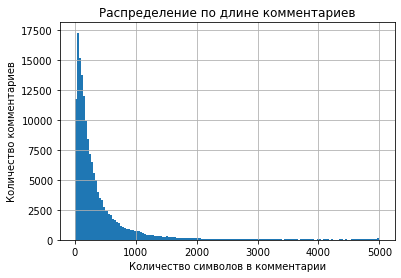

In [ ]:
comments_len.hist(bins = 150)
plt.title('Распределение по длине комментариев')
plt.xlabel('Количество символов в комментарии')
plt.ylabel('Количество комментариев');

In [ ]:
print('Самый короткий комментарий: {} символов'.format(min(comments_len)))
print('Самый длинный комментарий: {} символов'.format(max(comments_len)))
print('Средняя длина комментария: {} символов'.format(round(np.mean(comments_len))))
print('Медиана длины комментария: {} символов'.format(int(np.median(comments_len))))
print('85% комментариев короче {} символов'.format(int(np.percentile(comments_len, 85))))

Самый короткий комментарий: 6 символов
Самый длинный комментарий: 5000 символов
Средняя длина комментария: 394 символов
Медиана длины комментария: 205 символов
85% комментариев короче 663 символов


Отличаются ли средняя длина токсичного комментария и средняя длина положительного или нейтрального комментария?

In [ ]:
comments['len'] = comments_len

In [ ]:
print('Медиана длины токсичного комментария:', int(comments[comments.toxic == 1].len.median()))
print('Медиана длины положительного или нейтрального комментария:', int(comments[comments.toxic == 0].len.median()))

Медиана длины токсичного комментария: 128
Медиана длины положительного или нейтрального комментария: 216


В среднем, токсичные комментарии короче. Но модель на этом не построишь: необходимо обучить модель определять тональность текста.

Сначала нужно очистить тексты от ненужных символов (знаков пунктуации) и стоп-слов (часто употребляемых слов, не несущих дополнительной смысловой нагрузки), а также лемматизировать слова (привести их к словарной форме).

Напишем и применим функцию для предобработки текста:

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocessing(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    tokens = word_tokenize(text)
    text = [word for word in tokens if word not in stop_words]
    text = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(text)
    return text

In [ ]:
comments['text'] = comments['text'].apply(lambda x: preprocessing(x))

Посмотрим, как выглядят тексты после предобработки:

In [ ]:
comments

,text,toxic,len
0,explanation edits made username hardcore metal...,0,264
1,aww match background colour seemingly stuck th...,0,112
2,hey man really trying edit war guy constantly ...,0,233
3,make real suggestion improvement wondered sect...,0,622
4,sir hero chance remember page,0,67
...,...,...,...
159566,second time asking view completely contradicts...,0,295
159567,ashamed horrible thing put talk page,0,99
159568,spitzer umm there actual article prostitution ...,0,81
159569,look like actually put speedy first version de...,0,116


Теперь тексты относительно чистые и можно переходить к векторизации текстов и обучению моделей.

# Обучение и сравнение моделей

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix

Подготовим данные к обучению моделей машинного обучения.

Сначала выделим признаки и целевой признак, разделим датасет на обучающую и тестовую выборки:

In [ ]:
X = comments.text
y = comments.toxic
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y, random_state = 123)
X_train.shape, X_test.shape

((119678,), (39893,))

Чтобы модели машинного обучения могли работать с текстовыми данными, тексты необходимо перевести в векторный формат.

Воспользуемся показателем TF-IDF, который учитывает частоту и уникальность слова в тексте по сравнению с корпусом текстов. Используем величины TF-IDF как признаки.

In [ ]:
tf_idf = TfidfVectorizer(ngram_range = (1, 2))
X_train_tf = tf_idf.fit_transform(X_train)
X_test_tf = tf_idf.transform(X_test)

In [ ]:
X_train_tf.shape, X_test_tf.shape

((119678, 2127103), (39893, 2127103))

Количество признаков получилось очень большим: в разы больше, чем количество наблюдений. 

Попробуем обучить несколько моделей и сравнить их показатели F1 score на обучающей и тестовой выборках.

### Модель LogisticRegression

In [ ]:
%%time

params = {'C': [1, 3, 5, 7]}
logreg = LogisticRegression(class_weight = 'balanced', random_state = 123, max_iter = 5000)

logreg_cv = GridSearchCV(logreg, param_grid = params, scoring = 'f1', cv=3)
logreg_cv.fit(X_train_tf, y_train)

print('Оптимальные параметры:', logreg_cv.best_params_)
print('Лучший F1 score на кросс-валидации:', round(logreg_cv.best_score_, 4))

logreg_cv_pred = logreg_cv.predict(X_test_tf)
print('F1 score на тестовой выборке:', round(f1_score(y_test, logreg_cv_pred), 4))

Оптимальные параметры: {'C': 7}
Лучший F1 score на кросс-валидации: 0.7815
F1 score на тестовой выборке: 0.7802
CPU times: user 14min 1s, sys: 19min 16s, total: 33min 18s
Wall time: 9min 35s


Оптимальные параметры: {'C': 7}

Лучший F1 score на кросс-валидации: 0.7815

F1 score на тестовой выборке: 0.7802

Wall time: 9min 49s

### Модель LGBMClassifier

In [ ]:
%%time

params = {'n_estimators': [400, 500]}
gbm = LGBMClassifier(class_weight = 'balanced', random_state = 123)

gbm_cv = GridSearchCV(gbm, param_grid = params, scoring = 'f1', cv=3)
gbm_cv.fit(X_train_tf, y_train)

print('Оптимальные параметры:', gbm_cv.best_params_)
print('Лучший F1 score на кросс-валидации:', round(gbm_cv.best_score_, 4))

gbm_cv_pred = gbm_cv.predict(X_test_tf)
print('F1 score на тестовой выборке:', round(f1_score(y_test, gbm_cv_pred), 4))

Оптимальные параметры: {'n_estimators': 500}
Лучший F1 score на кросс-валидации: 0.7581
F1 score на тестовой выборке: 0.7656
CPU times: user 1h 28s, sys: 3.89 s, total: 1h 32s
Wall time: 15min 37s


Оптимальные параметры: {'n_estimators': 500}

Лучший F1 score на кросс-валидации: 0.7581

F1 score на тестовой выборке: 0.7656

Wall time: 15min 36s

### Модель SGDClassifier

In [ ]:
%%time

params = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
sgdc = SGDClassifier(class_weight = 'balanced', random_state = 123, max_iter = 5000)

sgdc_cv = GridSearchCV(sgdc, param_grid = params, scoring = 'f1', cv=3)
sgdc_cv.fit(X_train_tf, y_train)

print('Оптимальные параметры:', sgdc_cv.best_params_)
print('Лучший F1 score на кросс-валидации:', round(sgdc_cv.best_score_, 4))

sgdc_cv_pred = sgdc_cv.predict(X_test_tf)
print('F1 score на тестовой выборке:', round(f1_score(y_test, sgdc_cv_pred), 4))

Оптимальные параметры: {'alpha': 1e-05}
Лучший F1 score на кросс-валидации: 0.7797
F1 score на тестовой выборке: 0.7842
CPU times: user 13.8 s, sys: 11.8 s, total: 25.6 s
Wall time: 11.6 s


Оптимальные параметры: {'alpha': 1e-05}

Лучший F1 score на кросс-валидации: 0.7797

F1 score на тестовой выборке: 0.7842

Wall time: 11.8 s

### Сравнение моделей

Сравним показатели моделей:

In [ ]:
pd.DataFrame([['LogisticRegression', 0.7815, 0.7802, '9min 49s'], ['LGBMClassifier', 0.7581, 0.7656, '15min 36s'], ['SGDClassifier', 0.7797, 0.7842, '11.8 s']], columns = ['Модель', 'F1 (cv)', 'F1 (test)', 'Время обучения'])

,Модель,F1 (cv),F1 (test),Время обучения
0,LogisticRegression,0.7815,0.7802,9min 49s
1,LGBMClassifier,0.7581,0.7656,15min 36s
2,SGDClassifier,0.7797,0.7842,11.8 s


Оптимальное соотношение качества и скорости обучения показывает модель SGDClassifier: F1 0.7842 на тестовой выборке, модель обучается за несколько секунд.

Посмотрим, где ошибается модель и насколько сильно:

In [ ]:
y_test.value_counts()

0    35837
1     4056
Name: toxic, dtype: int64

In [ ]:
pd.DataFrame(confusion_matrix(y_test, sgdc_cv_pred), index = ['true_Normal', 'true_Toxic'], columns = ['pred_Normal', 'pred_Toxic'])

,pred_Normal,pred_Toxic
true_Normal,34885,952
true_Toxic,826,3230


Модель ошибочно определила 952 положительных или нейтральных комментариев как токсичные, а 826 токсичных комментариев ошибочно отнесла к нормальным.

# BERT

Попробуем обучить модели на эмбеддингах, учитывающих смысл и контекст слов. Используем нейронную сеть BERT, предобученную на большом корпусе англоязычных текстов.

In [ ]:
from tqdm import notebook
import torch
!pip install transformers
import transformers

Импортируем предобученную модель BertModel для создания признаков:

In [ ]:
model_class, tokenizer_class, pretrained_weights = (transformers.BertModel, \
                            transformers.BertTokenizer, 'bert-base-uncased')

In [ ]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Подготовим данные:

In [ ]:
vikishop = pd.read_csv('/content/drive/MyDrive/toxic_comments.csv')

In [ ]:
vikishop['text'] = vikishop['text'].map(lambda x: re.sub(r'[^a-zA-Z.,!?:;]', ' ', x))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(vikishop['text'], vikishop['toxic'], test_size = 0.15, stratify = vikishop['toxic'], random_state = 123)
X_train.shape, X_test.shape

((135635,), (23936,))

Проверим, что в полученных выборках доля токсичных комментариев такая же, как в исходном датасете (около 10%):

In [ ]:
round(y_train.mean(), 4), round(y_test.mean(), 4)

(0.1017, 0.1017)

In [ ]:
# токенизируем тренировочную выборку
tokenized = X_train.apply(lambda x: \
                                tokenizer.encode(x, add_special_tokens=True, truncation = True))

In [ ]:
# применим padding к векторам (приведем длины всех векторов к максимальной длине 512)
pad_vectors = np.array([i + [0]*(512 - len(i)) for i in tokenized.values])
pad_vectors.shape

(135635, 512)

In [ ]:
# создадим маску для важных токенов (укажем модели, какие токены нужно учитывать)
attention_mask = np.where(pad_vectors != 0, 1, 0)
attention_mask.shape

(135635, 512)

Сгенерируем эмбеддинги и сохраним их в переменную `features`.

In [ ]:
%%time
batch_size = 100
embeddings = [] 
for i in notebook.tqdm(range(pad_vectors.shape[0] // batch_size)):
        batch = torch.LongTensor(pad_vectors[batch_size * i : batch_size * (i + 1)]).cuda()
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size * i : batch_size * (i + 1)]).cuda()
        
        with torch.no_grad():
            model.cuda()
            batch_embeddings = model(batch, attention_mask = attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
        
        del batch
        del attention_mask_batch
        del batch_embeddings
        
features = np.concatenate(embeddings)

In [34]:
target = y_train[:len(features)]

Повторим процедуру для тестовой выборки:

In [36]:
# токенизируем тестовую выборку
tok_test = X_test.apply(lambda x: \
                        tokenizer.encode(x, add_special_tokens=True, truncation = True))

In [37]:
# применим padding к векторам (приведем длины всех векторов к максимальной длине 512)
pad_test = np.array([i + [0]*(512 - len(i)) for i in tok_test.values])
# создадим маску для важных токенов (укажем модели, какие токены нужно учитывать)
attention_test = np.where(pad_test != 0, 1, 0)

In [ ]:
# # создадим эмбеддинги, используя тензоры (многомерные векторы)
batch_size = 100
embeddings = []

for i in notebook.tqdm(range(pad_test.shape[0] // batch_size)):
  batch = torch.LongTensor(pad_test[batch_size * i : batch_size * (i + 1)]).cuda()
  attention_mask_batch = torch.LongTensor(attention_test[batch_size * i : batch_size * (i + 1)]).cuda()
  
  with torch.no_grad():
    model.cuda()
    batch_embeddings = model(batch, attention_mask = attention_mask_batch)
  embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  del batch
  del attention_mask_batch
  del batch_embeddings

test = np.concatenate(embeddings)

In [39]:
target_test = y_test[:len(test)]

Обучим те же модели, что и в прошлый раз, на этот раз на эмбеддингах BERT.

### Модель LogisticRegression

In [48]:
%%time

params = {'C': [1, 3, 5, 7]}
logreg = LogisticRegression(random_state = 123, max_iter = 5000)

logreg_cv = GridSearchCV(logreg, param_grid = params, scoring = 'f1', cv=3)
logreg_cv.fit(features, target)

print('Оптимальные параметры:', logreg_cv.best_params_)
print('Лучший F1 score на кросс-валидации:', round(logreg_cv.best_score_, 4))

logreg_cv_pred = logreg_cv.predict(test)
print('F1 score на тестовой выборке:', round(f1_score(target_test, logreg_cv_pred), 4))

Оптимальные параметры: {'C': 3}
Лучший F1 score на кросс-валидации: 0.7361
F1 score на тестовой выборке: 0.7199
CPU times: user 27min 9s, sys: 4min 15s, total: 31min 25s
Wall time: 7min 58s


Оптимальные параметры: {'C': 3}

Лучший F1 score на кросс-валидации: 0.7361

F1 score на тестовой выборке: 0.7199

Wall time: 7min 58s

### Модель LGBMClassifier

In [47]:
%%time

params = {'n_estimators': [400, 500]}
gbm = LGBMClassifier(random_state = 123)

gbm_cv = GridSearchCV(gbm, param_grid = params, scoring = 'f1', cv=3)
gbm_cv.fit(features, target)

print('Оптимальные параметры:', gbm_cv.best_params_)
print('Лучший F1 score на кросс-валидации:', round(gbm_cv.best_score_, 4))

gbm_cv_pred = gbm_cv.predict(test)
print('F1 score на тестовой выборке:', round(f1_score(target_test, gbm_cv_pred), 4))

Оптимальные параметры: {'n_estimators': 500}
Лучший F1 score на кросс-валидации: 0.6999
F1 score на тестовой выборке: 0.7064
CPU times: user 49min 38s, sys: 8.21 s, total: 49min 46s
Wall time: 13min 4s


Оптимальные параметры: {'n_estimators': 500}

Лучший F1 score на кросс-валидации: 0.6999

F1 score на тестовой выборке: 0.7064

Wall time: 13min 4s

### Модель SGDClassifier

In [46]:
%%time

params = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}
sgdc = SGDClassifier(random_state = 123, max_iter = 5000)

sgdc_cv = GridSearchCV(sgdc, param_grid = params, scoring = 'f1', cv=3)
sgdc_cv.fit(features, target)

print('Оптимальные параметры:', sgdc_cv.best_params_)
print('Лучший F1 score на кросс-валидации:', round(sgdc_cv.best_score_, 4))

sgdc_cv_pred = sgdc_cv.predict(test)
print('F1 score на тестовой выборке:', round(f1_score(target_test, sgdc_cv_pred), 4))

Оптимальные параметры: {'alpha': 0.001}
Лучший F1 score на кросс-валидации: 0.7128
F1 score на тестовой выборке: 0.7152
CPU times: user 1min 31s, sys: 7.12 s, total: 1min 38s
Wall time: 1min 30s


Оптимальные параметры: {'alpha': 0.001}

Лучший F1 score на кросс-валидации: 0.7128

F1 score на тестовой выборке: 0.7152

Wall time: 1min 30s

### Сравнение моделей

In [49]:
pd.DataFrame([['LogisticRegression', 0.7361, 0.7199, '7min 58s'], ['LGBMClassifier', 0.6999, 0.7064, '13min 4s'], ['SGDClassifier', 0.7128, 0.7152, '1min 30s']], columns = ['Модель', 'F1 (cv)', 'F1 (test)', 'Время обучения'])

,Модель,F1 (cv),F1 (test),Время обучения
0,LogisticRegression,0.7361,0.7199,7min 58s
1,LGBMClassifier,0.6999,0.7064,13min 4s
2,SGDClassifier,0.7128,0.7152,1min 30s


Модели, обученные на эмбеддингах BERT, показывают результат заметно хуже, чем модели, обученные на TF-IDF. Ни одна модель не показала нужный результат (F1 0.75 и выше).

# Выводы

- Проведена предобработка текстов для использования в моделях машинного обучения: очищение от ненужных символов, удаление стоп-слов, изменение регистра, токенизация, лемматизация и векторизация.


- Использованы два способа векторизации текстов: 1) на основе показателя TF-IDF, 2) с использованием эмбеддингов, сформированных с помощью предобученной нейронной сети BERT.


- Обучены разные модели, подобраны гиперпараметры на кросс-валидации для повышения метрики качества F1 score.


- Наилучшие результаты показали модели, обученные на признаках TF-IDF. 


- Модели, обученные на эмбеддингах предобученной модели BERT, не достигли минимального целевого показателя F1 0.75 (максимальный F1, которого удалось достичь, 0.72).


- Наилучший результат по качеству и скорости обучения показала модель SGDClassifier, обученная на признаках TF-IDF: F1 0.7842 на тестовой выборке, время обучения около 12 сек.